# RL solutions for combinatorial games: Temporal Difference Methods

**This notebook presents the implementation with little to no explanation, all details are covered in [the notebook on Monte Carlo Control](nim_MC_on_policy.ipynb)**

In [110]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [111]:
np.random.seed(42)

In [112]:
# A Simple Nim Game
class SimpleNim:
    def __init__(self, state):
        self.heaps = state
        self.turn = 0
        self.num_heaps = len(self.heaps)

    def get_state(self):
        if isinstance(self.heaps, list):
            return tuple(self.heaps)
        else:
            return tuple(self.heaps.tolist())

    def get_num_heaps(self):
        return self.num_heaps

    def get_heap_size(self, heap_index):
        if 0 <= heap_index < self.num_heaps:
            return self.heaps[heap_index]
        return None

    def is_game_over(self):
        return all(pebbles == 0 for pebbles in self.heaps)

    def make_move(self, heap_index, num_pebbles):
        if self.is_game_over():
            return False

        # Validate the move
        if 0 <= heap_index < self.num_heaps and 0 < num_pebbles <= self.heaps[heap_index]:
            self.heaps[heap_index] -= num_pebbles
            self.turn = 1 - self.turn  # Switch turns
            return True
        return False

    def winner(self):
        if self.is_game_over():
            return 1-self.turn
        return None

In [113]:
def nim_sum(s):
    xor = 0
    for heap in s:
        xor ^= heap
    return xor

In [114]:
def play_optimal(game):
    if game.is_game_over():
        return
    heaps = game.get_state()

    nimber = nim_sum(heaps)
    largest_index, largest = max(enumerate(heaps), key=lambda x:x[1])

    if nimber != 0:
        game.make_move(largest_index, largest - (largest^nimber)) # optimal move
    else:
        game.make_move(largest_index, 1) # take the move that progresses the game to the least possible extent and hope for a blunder

In [115]:
def play_random(game):
    if game.is_game_over():
        return
    heaps = game.get_state()

    index = np.random.randint(0, len(heaps))
    while heaps[index] == 0:
        index = np.random.randint(0, len(heaps))
    return (index, np.random.randint(0, heaps[index]+1))

In [116]:
def play_optimal_random(game, prob_optimal=1.0):
    random_choice = np.random.rand()
    if random_choice < prob_optimal:
        play_optimal(game)
    else:
        play_random(game)

In [117]:
# simple simulation of a nim game with both players using the optimal strategy
heaps = [10] * 3
game = SimpleNim(heaps)
while not game.is_game_over():
    play_optimal(game)
    print(game.get_state())
print("The winner is Player ", game.winner())

(0, 10, 10)
(0, 9, 10)
(0, 9, 9)
(0, 8, 9)
(0, 8, 8)
(0, 7, 8)
(0, 7, 7)
(0, 6, 7)
(0, 6, 6)
(0, 5, 6)
(0, 5, 5)
(0, 4, 5)
(0, 4, 4)
(0, 3, 4)
(0, 3, 3)
(0, 2, 3)
(0, 2, 2)
(0, 1, 2)
(0, 1, 1)
(0, 0, 1)
(0, 0, 0)
The winner is Player  0


## Defining State and Action Spaces:
**The State** is given by a configuration of heaps($\N_0$ means the set of naturals that includes zero):
$$ \mathcal S = \N_0^h $$
where h is the number of heaps
**Actions** are given by two tuples of heap number and number of pebbles to be taken out:
$$ \mathcal A(s) = H(s) \times \N $$ 
where $\N$ does not include zero and $H(s)$ is the set of heaps having non zero number of pebbles in the state s

In [118]:
# helper function that evaluates a policy based on whether the turn ends on a nim sum of 0
def is_optimal(s, a):
    s = list(s)
    if a[1] == 0: return False
    s[a[0]] -= a[1]
    return nim_sum(s) == 0

In [119]:
# for simplicity consider the version of the problem that starts off with same number of pebbles in each heap and 3 heaps
num_heaps = 3
initial_pebbles = 8
max_episodes = 100000

In [120]:
# Defining a class for epsilon greedy policy that has methods to update epsilon to account for GLIE conditions and to sample from epsilon greedy policy
class EpsilonGreedyPolicy:
    def __init__(self):
        self.epsilon = 1

    def update(self, epsilon):
        self.epsilon = epsilon

    def policy(self, s, Q):
        if s not in Q or np.random.random() < self.epsilon:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            return (index, 1)
        else:
            return max(Q[s], key=Q[s].get)

    # Returns a policy that does not explore
    def final_policy(self, s, Q):
        if s not in Q or len(Q[s]) == 0:
            return (0,0)
        return max(Q[s], key=Q[s].get)

In [121]:
class SimpleGreedyPolicy:
    def update(self, epsilon): pass

    def policy(self, s, Q):
        if s not in Q:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            return (index, 1)
        return max(Q[s], key=Q[s].get)

    def final_policy(self, s, Q):
        if s not in Q:
            return (0,0)
        return max(Q[s], key=Q[s].get)

In [122]:
def sample_step_zero_on_losing(game, A, prob_optimal=1.0):
    game.make_move(A[0],A[1])
    play_optimal_random(game, prob_optimal)
    S_next = game.get_state()
    if game.is_game_over() and game.winner() == 0: return 1, S_next
    else: return 0, S_next

### SARSA: On policy TD(0)

In [123]:
# SARSA with exploring starts
def sarsa(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, es=True, sample_step=sample_step_zero_on_losing, epsilon_schedule=None, prob_optimal=1.0):
    Q = {} # take default to be zero

    if epsilon_schedule is None: policy.update(0.05)

    for i in tqdm(range(max_episodes)):
        S = np.random.randint(0, initial_pebbles+1, num_heaps)
        while all(S == 0):
            S = np.random.randint(0, initial_pebbles+1, num_heaps)
        heap_num = np.random.randint(0,num_heaps)
        while S[heap_num] == 0:
            heap_num = np.random.randint(0,num_heaps)
        game = SimpleNim(S)

        S = tuple(S.tolist())
        if es: A = (heap_num, np.random.randint(1, S[heap_num]+1)) # Exploring start
        else: A = policy.policy(S, Q)

        while not game.is_game_over():
            R, S1 = sample_step(game, A, prob_optimal)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}
            if A1 not in Q[S1]:
                Q[S1][A1] = 0
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q[S1][A1]
            delta = target-Q[S][A]
            Q[S][A] = Q[S][A] + step_size*delta

            A = A1
            S = S1

        if epsilon_schedule is not None: policy.update(epsilon=epsilon_schedule[i])

    return policy, Q

In [124]:
# Epsilon Greedy and exploring starts
policy, Q = sarsa()

print(Q)

100%|██████████| 100000/100000 [00:02<00:00, 36226.90it/s]

{(1, 3, 2): {(2, 1): 0.02210684399229531, (0, 1): 0.03386867991736861, (1, 2): 0.015392338665670958, (2, 2): 0.027450264946923958, (1, 1): 0.7743627119539901, (1, 3): 0.008804947656142629}, (6, 3, 7): {(0, 5): 0.08371805991220077, (2, 3): 0.06826793378061659, (1, 2): 0.041102327156044685, (2, 5): 0.032133232338954903, (2, 7): 0.005511067514384532, (2, 6): 0.0727107158744457, (1, 3): 0.009096288648032351, (0, 2): 0.06429865377320082, (0, 3): 0.00935683364440549, (0, 1): 0.08475092293109283, (0, 4): 0.1358625000496119, (2, 2): 0.04091881301494916, (2, 4): 0.006677861346960157, (1, 1): 0.0629201230598526, (0, 6): 0.0038937634778022385, (2, 1): 0.07613841187143658}, (1, 0, 1): {(2, 1): 0.003992013367251221, (0, 1): 0.013269414832972387}, (0, 0, 0): {(0, 0): 0}, (3, 2, 1): {(1, 1): 0.03670183722159452, (2, 1): 0.031660139122256355, (0, 1): 0.7042121333694968, (0, 3): 0.01579753284719206, (1, 2): 0.019021144876171837, (0, 2): 0.011940365937461462}, (3, 7, 7): {(2, 6): 0.09295021838916832, (2

In [125]:
import itertools

def evaluate_on_winning_positions(policy, Q):
    fumbles = 0
    num_winning_pos = 0
    for s in itertools.product(range(initial_pebbles), repeat=num_heaps):
        if s == (0)*num_heaps: continue
        action = policy.final_policy(s, Q)
        if nim_sum(s) == 0: continue
        if not is_optimal(s, action):
            fumbles+=1
        num_winning_pos+=1
    return fumbles, num_winning_pos

In [126]:
def evaluate_using_fumbles(policy, Q):
    fumbles, num_winning_pos = evaluate_on_winning_positions(policy, Q)
    print('number of fumbles:', fumbles)
    print('total number of winning positions:', num_winning_pos)
    print('percentage of winning positions fumbled: {:.2f} %'.format(fumbles/num_winning_pos*100))

In [127]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 262
total number of winning positions: 448
percentage of winning positions fumbled: 58.48 %


In [128]:
# Epsilon Greedy but no exploring starts
policy, Q = sarsa(es=False)

print(Q)

100%|██████████| 100000/100000 [00:03<00:00, 32435.59it/s]

{(8, 5, 8): {(1, 1): 0.16899775440758077, (0, 1): 0.009486584228155778, (2, 1): 0.027402025991970176}, (8, 6, 8): {(1, 1): 0.07256542749534921, (0, 1): 0.015353647007177052, (2, 1): 0.0014749878670004238}, (8, 4, 8): {(1, 1): 0.0046804106269376575, (0, 1): 0.2972194397459132, (2, 1): 0.0672705378351585}, (8, 3, 8): {(1, 1): 0.10469077562122343, (2, 1): 0.0088032226162321, (0, 1): 0.011465013177549986}, (8, 2, 8): {(1, 1): 0.1345321146207163, (2, 1): 0.04556028967831361, (0, 1): 0.012484258269124648}, (8, 1, 8): {(1, 1): 0.1429563800589178, (0, 1): 0.008149756106261313, (2, 1): 0.07156095616895083}, (7, 0, 8): {(2, 1): 0.034287363936398904, (0, 1): 0.1262671995521852}, (6, 0, 7): {(2, 1): 0.1314188870047597, (0, 1): 0.033402543957675286}, (5, 0, 6): {(0, 1): 0.09385129773846144, (2, 1): 0.04072533856997894}, (4, 0, 4): {(2, 1): 0.05648155808693073, (0, 1): 0.056417848758642565}, (3, 0, 3): {(2, 1): 0.04989529768374367, (0, 1): 0.05011997188956488}, (2, 0, 2): {(0, 1): 0.0482389095985634

In [129]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 390
total number of winning positions: 448
percentage of winning positions fumbled: 87.05 %


In [130]:
# Apply the new rewards model with negative rewards for losses
def sample_step_negative_on_losing(game, A, prob_optimal=1.0):
    game.make_move(A[0],A[1])
    play_optimal_random(game, prob_optimal=prob_optimal)
    S_next = game.get_state()
    if game.is_game_over() and game.winner() == 0: return 1, S_next
    elif game.is_game_over(): return -1, S_next
    else: return 0, S_next

In [131]:
# Epsilon Greedy with exploring starts negative rewards on losing
policy, Q = sarsa(es=False, sample_step=sample_step_negative_on_losing)

print(Q)

100%|██████████| 100000/100000 [00:03<00:00, 28631.82it/s]

{(4, 5, 1): {(1, 1): 0.30800896439774517, (0, 1): 0.22492941700762376, (2, 1): -0.7036353562935477}, (6, 5, 1): {(0, 1): 0.24450705007056117, (1, 1): -7.414115297006124e-08, (2, 1): -0.06711006750897956}, (4, 4, 1): {(2, 1): 0.35648778396768466, (1, 1): 0.20692221542478312, (0, 1): 0.22213321193553787}, (3, 4, 0): {(0, 1): -0.7716370194740071, (1, 1): 0.3721324974382279}, (2, 2, 0): {(1, 1): -0.8168180803464805, (0, 1): -0.839710895386098}, (1, 1, 0): {(0, 1): -0.8733990072712676, (1, 1): -0.8274230308085971}, (0, 0, 0): {(0, 0): 0}, (0, 2, 2): {(2, 1): -0.9025216119586186, (1, 1): -0.8830583070012087}, (0, 8, 3): {(2, 1): -0.5823978407588227, (1, 1): -0.5860062989289231}, (0, 1, 1): {(1, 1): -0.9615088305165143, (2, 1): -0.9343879887511078}, (2, 1, 2): {(0, 1): -0.8022795378070265, (1, 1): 0.5292982990363801, (2, 1): -0.8675245246829456}, (2, 1, 3): {(0, 1): -0.7938793821969947, (2, 1): 0.455596920933027, (1, 1): -0.8261122014763826}, (2, 2, 4): {(1, 1): 0.2919028695253647, (0, 1): 0.

In [132]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 362
total number of winning positions: 448
percentage of winning positions fumbled: 80.80 %


In [133]:
# Epsilon Greedy with exploring starts negative rewards on losing
policy, Q = sarsa(sample_step=sample_step_negative_on_losing)

print(Q)

100%|██████████| 100000/100000 [00:03<00:00, 32638.16it/s]

{(2, 0, 2): {(2, 1): -0.9846576754570735, (0, 1): -0.9634815719510067, (0, 2): -0.9873339306056249, (2, 2): -0.9880758262962467}, (2, 2, 5): {(1, 2): -0.4318116087918329, (0, 1): 0.0938116501324689, (0, 2): -0.35547897012697727, (2, 1): -0.16276538628091528, (2, 3): -0.1227704683561403, (1, 1): 0.11314827364173882, (2, 5): 0.06112851086280546, (2, 2): -0.12315793415432294, (2, 4): 0.09546115359813684}, (1, 0, 1): {(2, 1): -0.9967022594857742, (0, 1): -0.9634154448116926}, (0, 0, 0): {(0, 0): 0}, (2, 1, 2): {(2, 1): -0.9390823268672756, (1, 1): 0.44601330995907, (0, 2): -0.3799053933656817, (0, 1): -0.9490923803223705, (2, 2): -0.24672023314275465}, (2, 3, 2): {(1, 2): 0.09919165095555764, (0, 2): -0.39688158110329597, (2, 2): -0.34050637642252196, (1, 3): 0.11620009673670088, (2, 1): 0.15172059523131465, (1, 1): -0.20952228056253464, (0, 1): 0.14229274412424905}, (0, 1, 1): {(1, 1): -0.9611852567599232, (2, 1): -0.9601990102263936}, (1, 0, 6): {(0, 1): -0.7519157331656512, (2, 5): 0.04

In [134]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 221
total number of winning positions: 448
percentage of winning positions fumbled: 49.33 %


In [ ]:
# providing a way to check performance more reliably
def evaluate_using_fumbles_averaged(train, num_iters=5, prob_optimal=1.0, sample_step=sample_step_negative_on_losing):
    num_winning_pos = 0
    total_fumbles = 0
    for i in range(num_iters):
        print(f'iteration {i+1}')
        policy, Q = train(sample_step=sample_step, prob_optimal=prob_optimal)

        fumbles, num_winning_pos = evaluate_on_winning_positions(policy, Q)
        total_fumbles += fumbles
    return total_fumbles, num_winning_pos

In [136]:
# num_iters = 5
# total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(sarsa, num_iters=num_iters)
# print('average number of fumbles: ', total_fumbles/num_iters)
# print('fumble rate: {:.2f}%'.format(total_fumbles/float(num_winning_pos*num_iters)*100))

### Q-Learning: Off-policy TD(0)

In [137]:
# Q-Learning
def qlearning(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, es=True, sample_step=sample_step_zero_on_losing, epsilon_schedule=None, epsilon_schedule_update=None, step_size_schedule=None, prob_optimal=1.0):
    Q = {} # take default to be zero

    if epsilon_schedule_update is None and epsilon_schedule is None: policy.update(0.05)

    for i in tqdm(range(max_episodes)):
        S = np.random.randint(0, initial_pebbles+1, num_heaps)
        while all(S == 0):
            S = np.random.randint(0, initial_pebbles+1, num_heaps)
        heap_num = np.random.randint(0,num_heaps)
        while S[heap_num] == 0:
            heap_num = np.random.randint(0,num_heaps)
        game = SimpleNim(S)

        S = tuple(S.tolist())
        if es: A = (heap_num, np.random.randint(1, S[heap_num]+1)) # Exploring start
        else: A = policy.policy(S, Q)

        while not game.is_game_over():
            R, S1 = sample_step(game, A, prob_optimal=prob_optimal)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}

            if len(Q[S1]) != 0: Q_max = Q[S1][max(Q[S1])]
            else: Q_max = 0

            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q_max
            delta = target-Q[S][A]
            current_step_size = step_size_schedule[i] if step_size_schedule is not None else step_size
            Q[S][A] = Q[S][A] + current_step_size*delta

            A = A1
            S = game.get_state()

        if epsilon_schedule_update is not None: epsilon_schedule_update(policy, i)
        if epsilon_schedule is not None: policy.update(epsilon_schedule[i])

    return policy, Q

In [138]:
policy, Q = qlearning(sample_step=sample_step_negative_on_losing)

print(Q)

100%|██████████| 100000/100000 [00:03<00:00, 33234.96it/s]

{(1, 2, 2): {(1, 1): -0.9247726678149657, (0, 1): -0.5356460739529654, (2, 1): -0.927804924363462, (2, 2): -0.5465564382728587, (1, 2): -0.5403330379288791}, (2, 2, 3): {(0, 1): -0.12909820508623598, (2, 3): -0.10876303949708557, (0, 2): -0.3520827589992665, (2, 1): -0.304500600656141, (1, 2): -0.3555109652479661, (1, 1): -0.1249848045402579, (2, 2): -0.07106814494926163}, (1, 1, 0): {(0, 1): -0.9699486291537953, (1, 1): -0.9960180382872624}, (0, 0, 0): {}, (1, 0, 1): {(2, 1): -0.976031077537109, (0, 1): -0.9763274732306}, (6, 0, 1): {(0, 2): -0.2518181240502381, (2, 1): -0.7711749712750526, (0, 1): -0.15699909851972182, (0, 4): -0.10937550228977157, (0, 3): -0.19041104160714312, (0, 6): -0.18292719311245315, (0, 5): 0.03655112825041821}, (4, 0, 4): {(0, 1): -0.9770358218922867, (0, 2): -0.9745844483832177, (2, 2): -0.9744304679149337, (2, 1): -0.9769272155355547, (0, 3): -0.9381104084153538, (2, 4): -0.9748785647366873, (2, 3): -0.9728039058528613, (0, 4): -0.9747999607930277}, (5, 7,

In [139]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 171
total number of winning positions: 448
percentage of winning positions fumbled: 38.17 %


In [140]:
def simplest_schedule(policy, i):
    policy.update(1.0/(i+1))


In [141]:
policy, Q = qlearning(sample_step=sample_step_negative_on_losing, epsilon_schedule_update=simplest_schedule)

100%|██████████| 100000/100000 [00:02<00:00, 34159.16it/s]


In [142]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 146
total number of winning positions: 448
percentage of winning positions fumbled: 32.59 %


In [143]:
def get_geometric_schedule(decay):
    epsilon_schedule = []
    for i in range(max_episodes):
        epsilon_schedule.append((1-decay)*(decay**i))
    return epsilon_schedule

In [144]:
policy, Q = qlearning(sample_step=sample_step_negative_on_losing, epsilon_schedule=get_geometric_schedule(decay=0.7))
evaluate_using_fumbles(policy, Q)

100%|██████████| 100000/100000 [00:02<00:00, 33840.87it/s]

number of fumbles: 173
total number of winning positions: 448
percentage of winning positions fumbled: 38.62 %


In [145]:
fumble_rate_by_decay = []
decays = np.linspace(0.1, 0.9, 9)

for decay in decays:
    print(f'decay: {decay}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(qlearning, num_iters=num_iters)

    fumble_rate_by_decay.append(float(total_fumbles)/float(num_winning_pos*num_iters))

decay: 0.1
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 32916.69it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 33182.80it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34334.89it/s]


decay: 0.2
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 33844.18it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 33911.41it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34577.46it/s]


decay: 0.30000000000000004
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 33570.54it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 33882.64it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34125.30it/s]


decay: 0.4
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 33785.43it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 33189.91it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34434.54it/s]


decay: 0.5
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 34838.12it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 34367.91it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 33698.57it/s]


decay: 0.6
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 34755.00it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 34296.19it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34706.35it/s]


decay: 0.7000000000000001
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 34545.23it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 34006.59it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34438.91it/s]


decay: 0.8
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 34001.92it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 34225.02it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 33859.93it/s]


decay: 0.9
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 34959.33it/s]


iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 33937.99it/s]


iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 34450.06it/s]


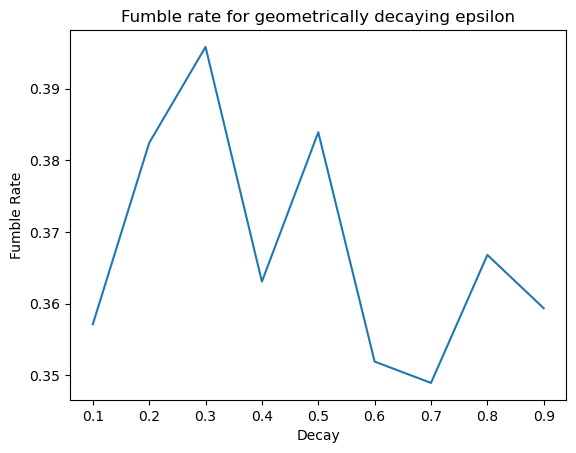

In [146]:
plt.plot(decays, fumble_rate_by_decay)
plt.xlabel('Decay')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for geometrically decaying epsilon')
plt.show()

In [147]:
policy, Q = qlearning(sample_step=sample_step_negative_on_losing, epsilon_schedule=get_geometric_schedule(decay=0.5))
evaluate_using_fumbles(policy, Q)

100%|██████████| 100000/100000 [00:02<00:00, 34965.18it/s]

number of fumbles: 177
total number of winning positions: 448
percentage of winning positions fumbled: 39.51 %


In [148]:
def get_inverse_time_decay_step_size_schedule(initial_alpha=0.1, decay=0.01):
    return [initial_alpha / (1.0 + decay * i) for i in range(max_episodes)]

def get_exponential_step_size_schedule(initial_alpha=0.1, decay=0.99):
    return [initial_alpha * (decay ** i) for i in range(max_episodes)]

def get_step_wise_decay_schedule(initial_alpha=0.1, decay=0.9, num_steps=10):
    return [initial_alpha * (decay ** (i // num_steps)) for i in range(max_episodes)]

In [149]:
for step_size_schedule in [
    ('inverse time decay', get_inverse_time_decay_step_size_schedule()),
    ('exponential decay', get_exponential_step_size_schedule()),
    ('step-wise decay', get_step_wise_decay_schedule())
]:
    print("Using step size schedule:", step_size_schedule[0])
    policy, Q = qlearning(sample_step=sample_step_negative_on_losing, step_size_schedule=step_size_schedule[1], epsilon_schedule=get_geometric_schedule(decay=0.5))
    evaluate_using_fumbles(policy, Q)

Using step size schedule: inverse time decay


100%|██████████| 100000/100000 [00:02<00:00, 33746.49it/s]


number of fumbles: 157
total number of winning positions: 448
percentage of winning positions fumbled: 35.04 %
Using step size schedule: exponential decay


100%|██████████| 100000/100000 [00:02<00:00, 36268.92it/s]


number of fumbles: 292
total number of winning positions: 448
percentage of winning positions fumbled: 65.18 %
Using step size schedule: step-wise decay


100%|██████████| 100000/100000 [00:02<00:00, 37016.67it/s]

number of fumbles: 290
total number of winning positions: 448
percentage of winning positions fumbled: 64.73 %


In [150]:
policy, Q = qlearning(sample_step=sample_step_negative_on_losing, epsilon_schedule=get_geometric_schedule(decay=0.5), prob_optimal=0.9)
evaluate_using_fumbles(policy, Q)

100%|██████████| 100000/100000 [00:03<00:00, 32674.09it/s]

number of fumbles: 236
total number of winning positions: 448
percentage of winning positions fumbled: 52.68 %


In [151]:
# compare fumbles over different probabilities of optimal play
prob_optimal_values = np.linspace(0.1, 0.9, 9)
fumble_rate_by_prob_optimal = []

for prob_optimal in prob_optimal_values:
    print(f'probability of optimal play: {prob_optimal}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(qlearning, num_iters=num_iters, prob_optimal=prob_optimal)

    fumble_rate_by_prob_optimal.append(float(total_fumbles)/float(num_winning_pos*num_iters))

plt.plot(prob_optimal_values, fumble_rate_by_prob_optimal)
plt.xlabel('Probability of Optimal Play')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for different probabilities of optimal play')
plt.show()

probability of optimal play: 0.1


TypeError: evaluate_using_fumbles_averaged() got an unexpected keyword argument 'prob_optimal'

### Sarsa($\lambda$)

In [ ]:
# SARSA lambda
def sarsa_lambda(lamb=0.2, gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, es=True, sample_step=sample_step_zero_on_losing, epsilon_schedule=None, move_opponent=play_optimal):
    Q = {} # take default to be zero
    E = {} # eligibility traces

    if epsilon_schedule is None: policy.update(0.05)

    for i in tqdm(range(max_episodes)):
        S = np.random.randint(0, initial_pebbles+1, num_heaps)
        while all(S == 0):
            S = np.random.randint(0, initial_pebbles+1, num_heaps)
        heap_num = np.random.randint(0,num_heaps)
        while S[heap_num] == 0:
            heap_num = np.random.randint(0,num_heaps)
        game = SimpleNim(S)

        S = tuple(S.tolist())
        if es: A = (heap_num, np.random.randint(1, S[heap_num]+1)) # Exploring start
        else: A = policy.policy(S, Q)

        while not game.is_game_over():
            R, S1 = sample_step(game, A, move_opponent=move_opponent)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}
            if A1 not in Q[S1]:
                Q[S1][A1] = 0
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q[S1][A1]
            delta = target-Q[S][A]

            if S not in E:
                E[S] = {}
            if A not in E[S]:
                E[S][A] = 0

            E[S][A] += 1  # Increment eligibility trace for the current state-action pair

            # Update all state-action pairs
            for s in Q:
                for a in Q[s]:
                    if s not in E:
                        E[s] = {}
                    if a not in E[s]:
                        E[s][a] = 0

                    # Update Q-value using eligibility trace
                    Q[s][a] += step_size * delta * E[s][a]

                    # Decay eligibility traces
                    E[s][a] *= lamb * gamma

            A = A1
            S = S1

        # Reset eligibility traces for the next episode
        E = {}

        if epsilon_schedule is not None: policy.update(epsilon=epsilon_schedule[i])

    return policy, Q

In [ ]:
# plot the fumble rate for SARSA lambda for different lambdas
lambdas = [0.1, 0.2, 0.5, 0.8]
fumble_rates = []

for lamb in lambdas:
    print(f'Lambda: {lamb}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(sarsa_lambda, num_iters=num_iters)
    fumble_rates.append(float(total_fumbles) / float(num_winning_pos * num_iters))
    print('Average number of fumbles:', total_fumbles / num_iters)
    print('Fumble rate: {:.2f}%'.format(fumble_rates[-1] * 100))

plt.plot(lambdas, fumble_rates)
plt.xlabel('Lambda')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for different lambda values in SARSA(lambda)')
plt.show()

Lambda: 0.1
iteration 1


 76%|███████▌  | 75845/100000 [07:31<02:23, 167.92it/s]


KeyboardInterrupt: 